In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from spectral import open_image, envi
from sklearn.preprocessing import MinMaxScaler
import re

# spatial
import xarray as xa
import rasterio
import pyproj
import rioxarray
import xesmf as xe

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import joblib


from sklearn.metrics import r2_score
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from statsmodels.multivariate.manova import MANOVA

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting, ml_utils

In [22]:
corr_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img"
corr_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img.hdr"
mask_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img"
mask_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img.hdr"

validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")

hs_mask_metadata = open_image(mask_fp_hdr)
hs_corrected_metadata = open_image(corr_fp_hdr)
print("masked:", hs_mask_metadata)
print("corrected:", hs_corrected_metadata)
hs_corrected_data = open_image(corr_fp_hdr).load()

masked: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_mask_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:             1
	Interleave:        BSQ
	Quantization:   8 bits
	Data format:     uint8
corrected: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_corr_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:           246
	Interleave:        BSQ
	Quantization:  32 bits
	Data format:   float32


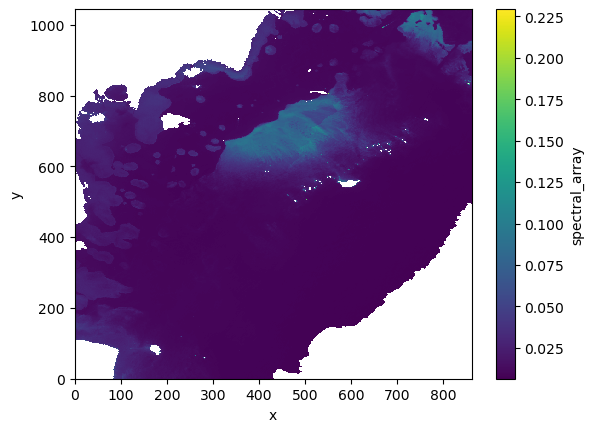

In [4]:
spatial_xy_xa = ml_utils.envi_to_xarray_with_latlon(corr_fp)
mask_xa = ml_utils.envi_to_xarray_with_latlon(mask_fp)
# broadcast mask_xa to have same number of bands as scene_xa
mask_xa = mask_xa.broadcast_like(spatial_xy_xa)
mask_xa.values = np.broadcast_to(mask_xa.values[0], mask_xa.shape)
masked_scene_xa = spatial_xy_xa.where(mask_xa == 1, np.nan)
masked_scene_xa.name = "spectral_array"
# assign band values actual wavelength values
masked_scene_xa.coords["band"] = hs_corrected_metadata.bands.centers

# visualise data
mean_scene_xa = masked_scene_xa.median(dim="band", skipna=True)
mean_scene_xa.plot.imshow();

In [5]:
scene_xa = ml_utils.regrid_with_xesmf(masked_scene_xa)
scene_xa.name = "site"

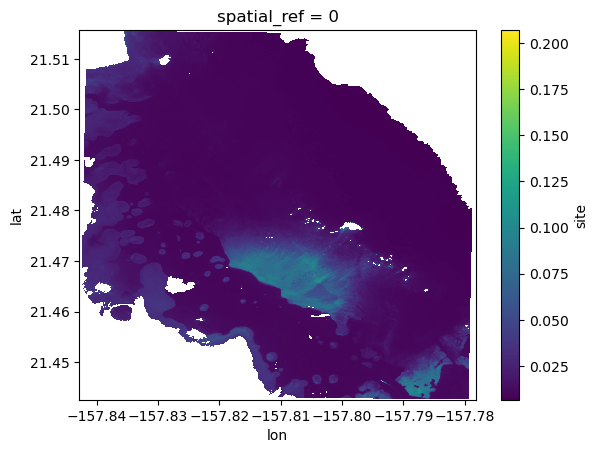

In [6]:
scene_xa.median(dim="band", skipna=True).plot()

In [9]:
masked_scene_vals = scene_xa.values.reshape(scene_xa.sizes["band"], -1)

wvs = hs_corrected_metadata.bands.centers
hs_vals = pd.DataFrame(masked_scene_vals.T, columns=wvs)
# process: deglint and crop to sensor range
hs_vals = spectrum_utils.deglint_spectra(hs_vals)
hs_vals = spectrum_utils.crop_spectra_to_range(hs_vals)

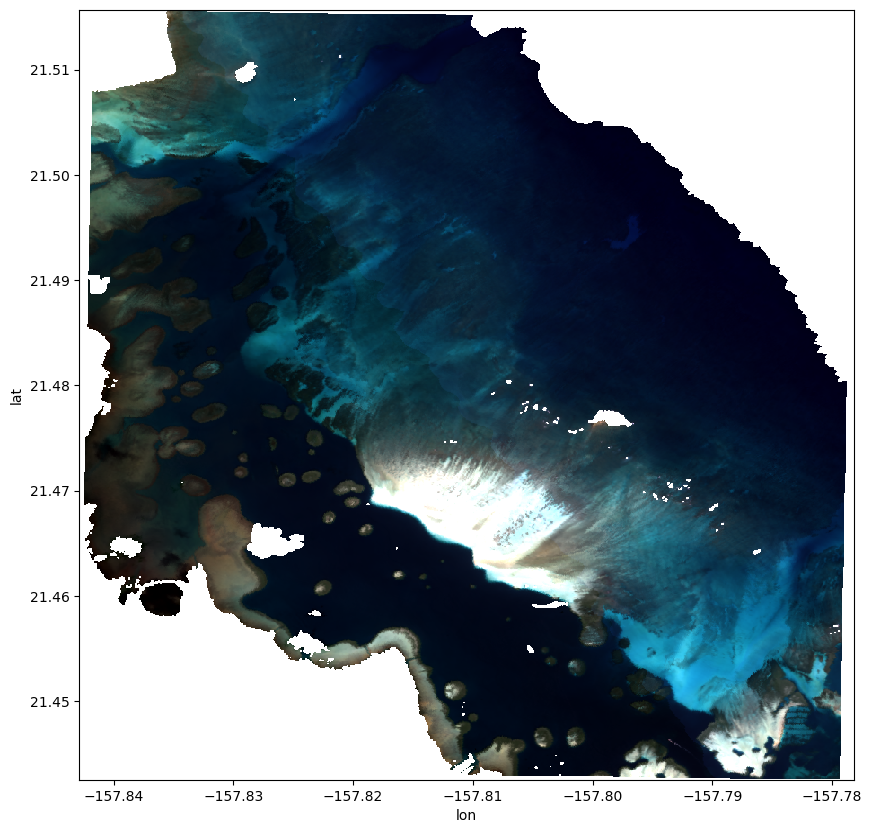

In [10]:
# plot, taking band values as RGB values
vis_percentiles=(0.1, 99.9)
rgb_vals = plotting.generate_spectra_color(hs_vals, vis_percentiles=vis_percentiles)

# reform rgb_vals back to scene_xa dataset
rgb_xa = xa.DataArray(rgb_vals.reshape(len(scene_xa.lat), len(scene_xa.lon), -1), dims=("lat", "lon", "rgb"), coords={"lat": scene_xa.lat, "lon": scene_xa.lon, "rgb": ["r", "g", "b"]})
rgb_xa.plot.imshow(rgb="rgb", figsize=(10, 10), robust=True);

In [85]:
scene_xa.rio.crs

CRS.from_epsg(4326)

In [83]:
# save scene_xa to disk
scene_xa.to_netcdf(file_ops.TMP_DIR_FP / "kaneohe_hs_masked.nc")

## Comparison with validation

In [30]:
print("validation sites:", validation_data.Locale.unique())
(X_train, X_test), (y1,y2), depth_labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="depth", data_source="prism_fits").generate_data()
depth_labels = depth_labels[~depth_labels.index.duplicated(keep='first')]
kbay_indices = validation_data[validation_data.Locale == "Kaneohe Bay"].index

validation sites: ['Lizard Island' 'Heron Island' 'Lanai' 'Maui' 'Hawaii' 'Kaneohe Bay'
 'Palau']


In [31]:
print("validation sites:", validation_data.Locale.unique())
(X_train, X_test), (y1,y2), benthic_labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="prism_fits").generate_data()
benthic_labels = benthic_labels[~benthic_labels.index.duplicated(keep='first')]
kbay_indices = validation_data[validation_data.Locale == "Kaneohe Bay"].index

validation sites: ['Lizard Island' 'Heron Island' 'Lanai' 'Maui' 'Hawaii' 'Kaneohe Bay'
 'Palau']


In [32]:
# get indices of validation data in Kaneohe Bay
kbay_validation = validation_data.loc[kbay_indices]
# join labels to validation data
kbay_labels = depth_labels.loc[kbay_indices.intersection(depth_labels.index)]
kbay_benthic_labels = benthic_labels.loc[kbay_indices.intersection(benthic_labels.index)]
# kbay_validation = kbay_validation.join(kbay_labels)

extent = (kbay_validation.X >= rgb_xa.lon.values.min()) & (kbay_validation.X <= rgb_xa.lon.values.max()) & (kbay_validation.Y >= rgb_xa.lat.values.min()) & (kbay_validation.Y <= rgb_xa.lat.values.max())
kbay_validation.loc[extent]

X          Y Campaign       Locale  Station        TimeUTC  \
1151 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1152 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1153 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1154 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1155 -157.828916  21.492282   Hawaii  Kaneohe Bay      618  2/16/17 22:04   
...          ...        ...      ...          ...      ...            ...   
1559 -157.815017  21.508195   Hawaii  Kaneohe Bay      619  2/16/17 23:44   
1560 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1561 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1562 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1563 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   

          TimeLocal  Depth Metabolism Optics  ... othInvert  othOther  \
1151   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1152   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1153   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1154   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1155  2/16/17 11:04    4.9        NaN    NaN  ...         0         0   
...             ...    ...        ...    ...  ...       ...       ...   
1559  2/16/17 12:44    4.3        NaN    NaN  ...         0         0   
1560  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   
1561  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   
1562  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   
1563  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   

      othSponge  othUrchin  sedLimest  sedMud  sedRubble  sedSand  ROInumber  \
1151          0          0          0       0          0        4        199   
1152          0          0          0       0          0        4        199   
1153          0          0          0       0          0        4        199   
1154          0          0          0       0          0        4        199   
1155          0          0          0       0          0        9        200   
...         ...        ...        ...     ...        ...      ...        ...   
1559          0          0          0       0          0        3        287   
1560          0          0          0       0          0        2        288   
1561          0          0          0       0          0        2        288   
1562          0          0          0       0          0        2        288   
1563          0          0          0       0          0        2        288   

                            Flightline  
1151  prm20170306t194614_corr_v1w3_img  
1152  prm20170306t194614_corr_v1w3_img  
1153  prm20170306t194614_corr_v1w3_img  
1154  prm20170306t194614_corr_v1w3_img  
1155  prm20170306t194614_corr_v1w3_img  
...                                ...  
1559  prm20170306t202626_corr_v1w3_img  
1560  prm20170306t202626_corr_v1w3_img  
1561  prm20170306t202626_corr_v1w3_img  
1562  prm20170306t202626_corr_v1w3_img  
1563  prm20170306t202626_corr_v1w3_img  

[395 rows x 34 columns]

In [33]:
kbay_X_train = X_train.loc[X_train.index.intersection(kbay_indices)].loc[extent]
kbay_X_train=kbay_X_train[~kbay_X_train.index.duplicated(keep='first')]
kbay_train_inds=kbay_X_train.index
kbay_X_test = X_test.loc[X_test.index.intersection(kbay_indices)].loc[extent]
kbay_X_test=kbay_X_test[~kbay_X_test.index.duplicated(keep='first')]
kbay_test_inds=kbay_X_test.index

In [34]:
kbay_train_meta = kbay_validation.loc[kbay_train_inds]
kbay_test_meta = kbay_validation.loc[kbay_test_inds]

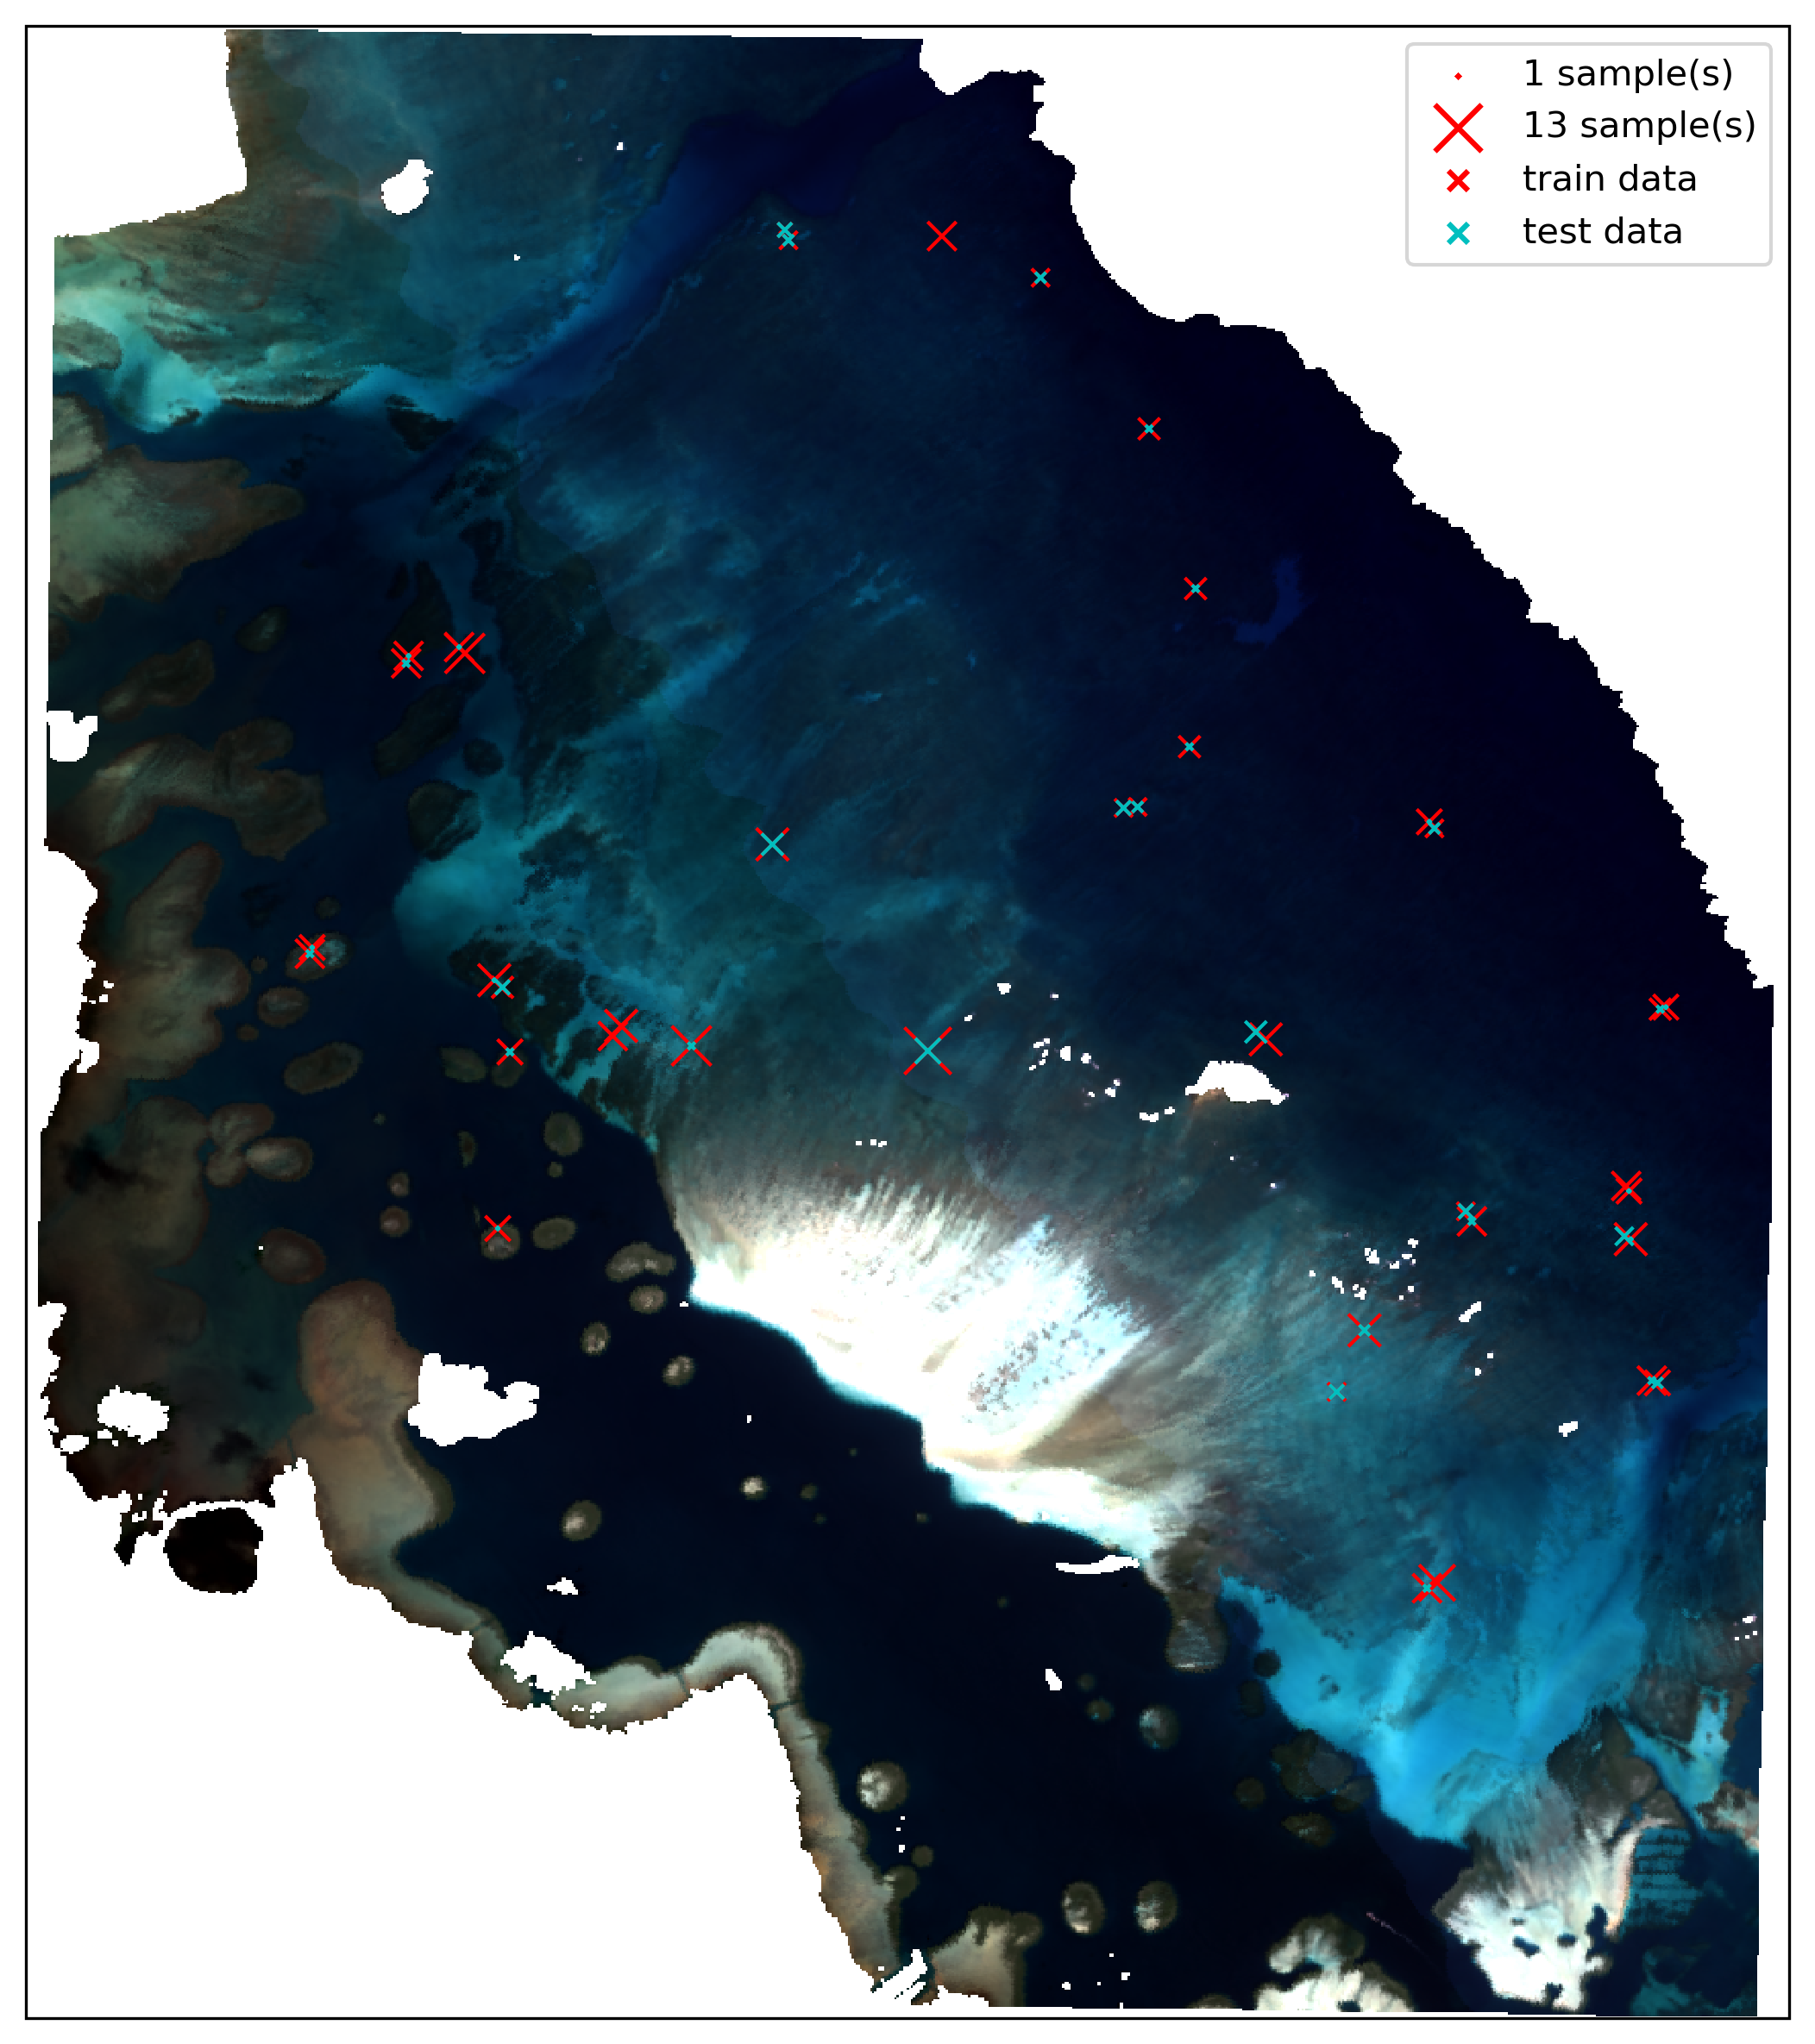

In [35]:
# join labels with validation data
kbay_validation_data = validation_data.loc[kbay_indices].join(kbay_benthic_labels, rsuffix="_label")
kbay_validation_data = kbay_validation_data.loc[kbay_indices].join(kbay_labels, rsuffix="_label")
# kbay_validation_data = validation_data.iloc[kbay_indices]
# select validation data within limits of rgb_xa
kbay_validation_data = kbay_validation_data[(kbay_validation_data.X >= rgb_xa.lon.values.min()) & (kbay_validation_data.X <= rgb_xa.lon.values.max()) & (kbay_validation_data.Y >= rgb_xa.lat.values.min()) & (kbay_validation_data.Y <= rgb_xa.lat.values.max())]

# count the number of samples at each site
train_sample_counts = kbay_train_meta.groupby(['X', 'Y']).size().reset_index(name='counts')
test_sample_counts = kbay_test_meta.groupby(['X', 'Y']).size().reset_index(name='counts')

# plot sites on the prediction map
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
rgb_xa.plot.imshow(rgb="rgb", ax=ax, robust=True)
ax.scatter(train_sample_counts.X, train_sample_counts.Y, s=train_sample_counts.counts ** 2, color="red", marker="x", lw=1, alpha=1)
ax.scatter(test_sample_counts.X, test_sample_counts.Y, s=test_sample_counts.counts ** 2, color="c", marker="x", lw=1, alpha=1)
plt.scatter([],[], marker="x", s=min(min(train_sample_counts.counts), min(test_sample_counts.counts)) ** 2, color="red", label=f"{min(min(train_sample_counts.counts), min(test_sample_counts.counts))} sample(s)")
plt.scatter([],[], marker="x", s=max(max(train_sample_counts.counts), max(test_sample_counts.counts)) ** 2, color="red", label=f"{max(max(train_sample_counts.counts), max(test_sample_counts.counts))} sample(s)")
plt.scatter([],[], marker="x", s=30, color="red", label="train data")
plt.scatter([],[], marker="x", s=30, color="c", label="test data")
plt.legend();

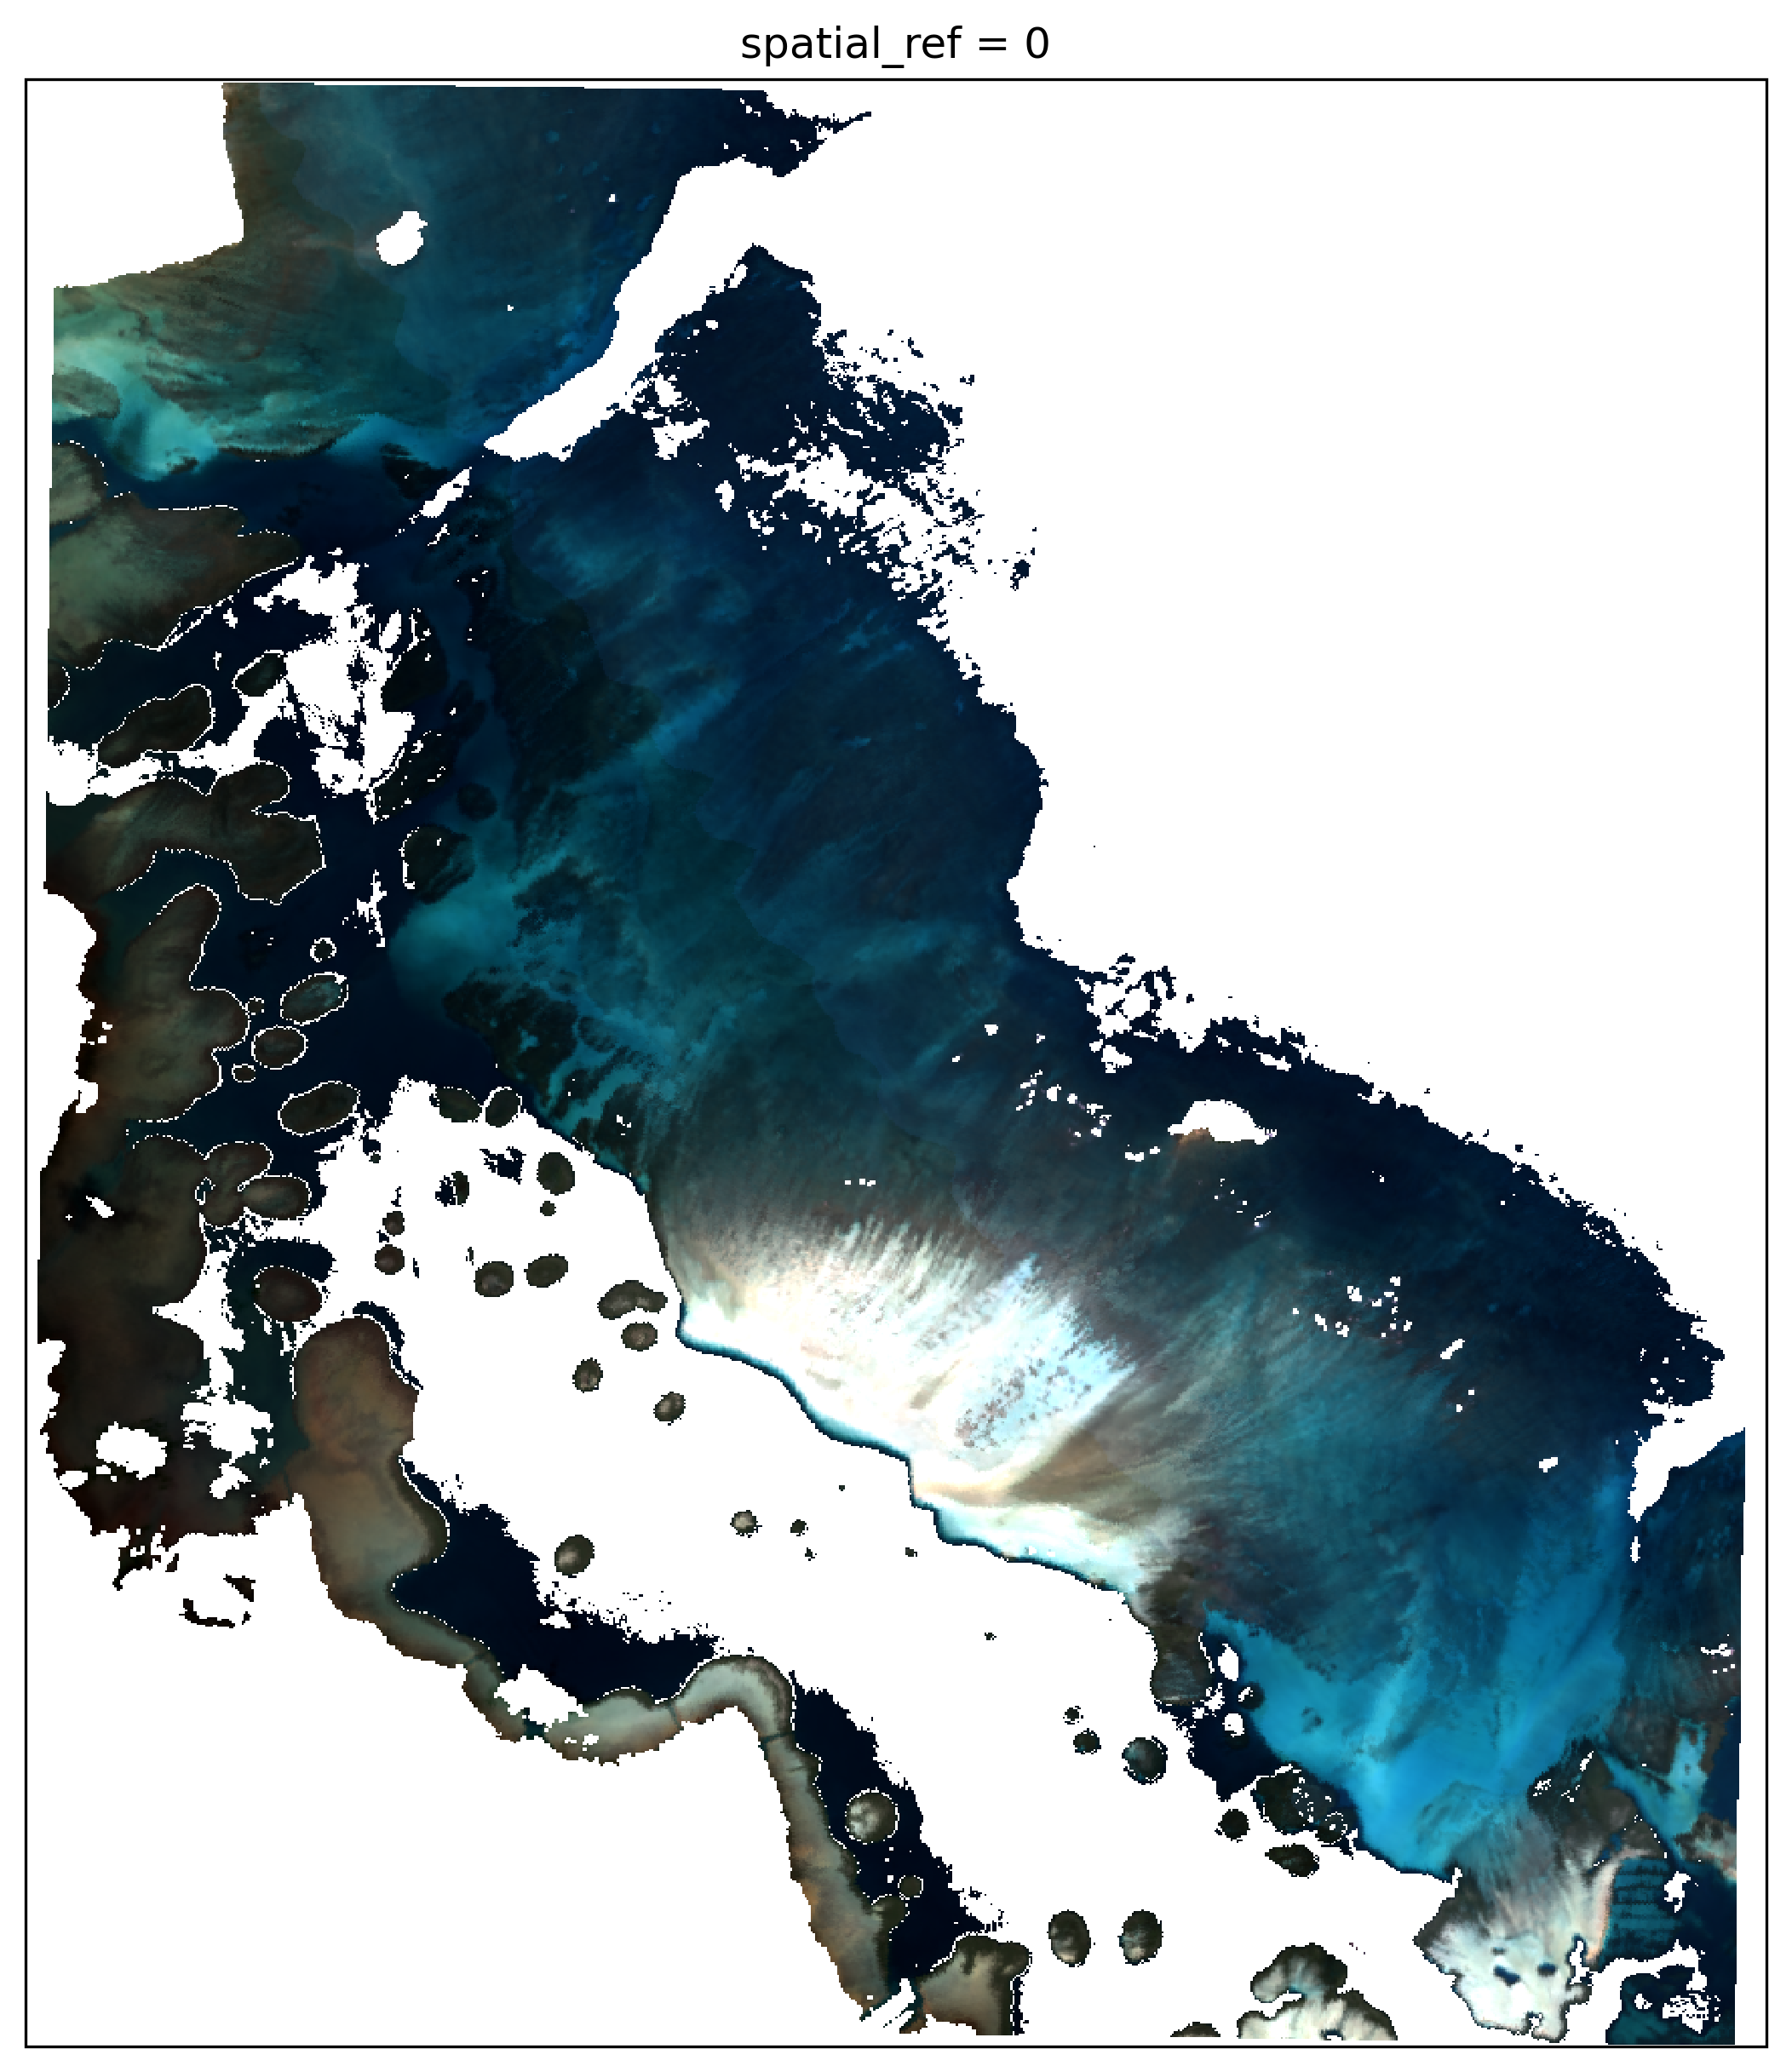

In [37]:
depth_masked_scene = rgb_xa.where(depth_mlp_inferred["depth_pred"] <= 8, np.nan)
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
depth_masked_scene.plot.imshow(rgb="rgb", ax=ax, robust=True);

In [39]:
all_predictions_df = masked_endmember_rf_inferred.drop_vars(['spectra', 'band']).to_dataframe()

In [ ]:
kbay_validation_data

In [40]:
import numpy as np

# Verify latitude matching
lat_diff = np.abs(masked_endmember_rf_inferred.lat.values - kbay_validation_data.Y.values[:, np.newaxis])
kbay_validation_data["pixel_y"] = np.argmin(lat_diff, axis=1)

# Verify longitude matching
lon_diff = np.abs(masked_endmember_rf_inferred.lon.values - kbay_validation_data.X.values[:, np.newaxis])
kbay_validation_data["pixel_x"] = np.argmin(lon_diff, axis=1)

np.argmin(lon_diff, axis=1).shape

(395,)

In [41]:
kbay_validation_data.columns

Index(['X', 'Y', 'Campaign', 'Locale', 'Station', 'TimeUTC', 'TimeLocal',
       'Depth', 'Metabolism', 'Optics', 'Comments', 'algCCA', 'algCyano',
       'algMacBrn', 'algMacGrn', 'algMacMix', 'algMacRed', 'algMacUnk',
       'algTurf', 'crlCoral', 'crlBleach', 'othOcto', 'othSeagr', 'othClam',
       'othInvert', 'othOther', 'othSponge', 'othUrchin', 'sedLimest',
       'sedMud', 'sedRubble', 'sedSand', 'ROInumber', 'Flightline', 'algae',
       'coral', 'sand', 'Depth_label', 'pixel_y', 'pixel_x'],
      dtype='object')

In [42]:
algae_preds = []
coral_preds = []
sand_preds = []

for i in range(kbay_validation_data.shape[0]):
    point = endmember_rf_inferred.sel(lat=kbay_validation_data.Y.iloc[i], lon=kbay_validation_data.X.iloc[i], method="nearest")
    algae_preds.append(point.algae_pred.values)
    coral_preds.append(point.coral_pred.values)
    sand_preds.append(point.sand_pred.values)

# plot algae_preds, coral_preds, sand_preds

In [43]:
kbay_validation_data.columns

Index(['X', 'Y', 'Campaign', 'Locale', 'Station', 'TimeUTC', 'TimeLocal',
       'Depth', 'Metabolism', 'Optics', 'Comments', 'algCCA', 'algCyano',
       'algMacBrn', 'algMacGrn', 'algMacMix', 'algMacRed', 'algMacUnk',
       'algTurf', 'crlCoral', 'crlBleach', 'othOcto', 'othSeagr', 'othClam',
       'othInvert', 'othOther', 'othSponge', 'othUrchin', 'sedLimest',
       'sedMud', 'sedRubble', 'sedSand', 'ROInumber', 'Flightline', 'algae',
       'coral', 'sand', 'Depth_label', 'pixel_y', 'pixel_x'],
      dtype='object')

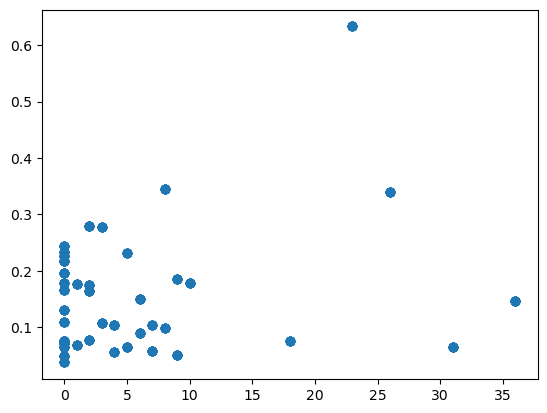

In [44]:
# plt.scatter(kbay_validation_data.algae, algae_preds)
# plt.scatter(kbay_validation_data.coral, coral_preds)
plt.scatter(kbay_validation_data.sand, sand_preds)

21.480649 -157.825682
3.4
inferred depth: 6.559524263094682
labels 0.34 0.35 0.31
predictions 0.5879565217391302 0.37219413549039443 0.06404347826086944


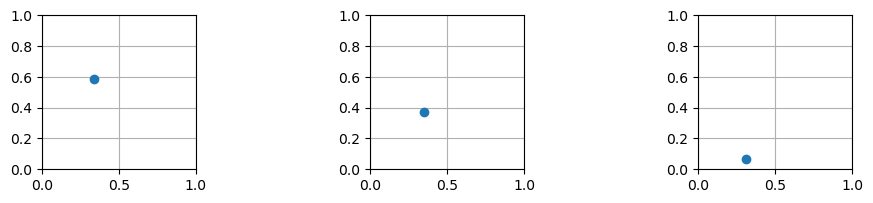

In [46]:
i = 40
# for i in range(len(kbay_validation_data)):
print(kbay_validation_data.Y.iloc[i], kbay_validation_data.X.iloc[i])
algae_label = kbay_validation_data.algae.iloc[i]/100
coral_label = kbay_validation_data.coral.iloc[i]/100
sand_label = kbay_validation_data.sand.iloc[i]/100
print(kbay_validation_data.Depth.iloc[i])
print("inferred depth:", depth_mlp_inferred.sel(lat=kbay_validation_data.Y.iloc[i], lon=kbay_validation_data.X.iloc[i], method="nearest").depth_pred.values)
print("labels", algae_label, coral_label, sand_label)

point = endmember_rf_inferred.sel(lat=kbay_validation_data.Y.iloc[i], lon=kbay_validation_data.X.iloc[i], method="nearest")
algae_pred = point.algae_pred.values
coral_pred = point.coral_pred.values
sand_pred = point.sand_pred.values
print("predictions", algae_pred, coral_pred, sand_pred)

fig, ax = plt.subplots(1,3, figsize=(12, 2))

ax[0].plot(algae_label, algae_pred, 'o')
ax[1].plot(coral_label, coral_pred, 'o')
ax[2].plot(sand_label, sand_pred, 'o')
[a.set_xlim(0, 1) for a in ax];
[a.set_ylim(0, 1) for a in ax];
[a.set_aspect('equal') for a in ax];
[a.grid() for a in ax];

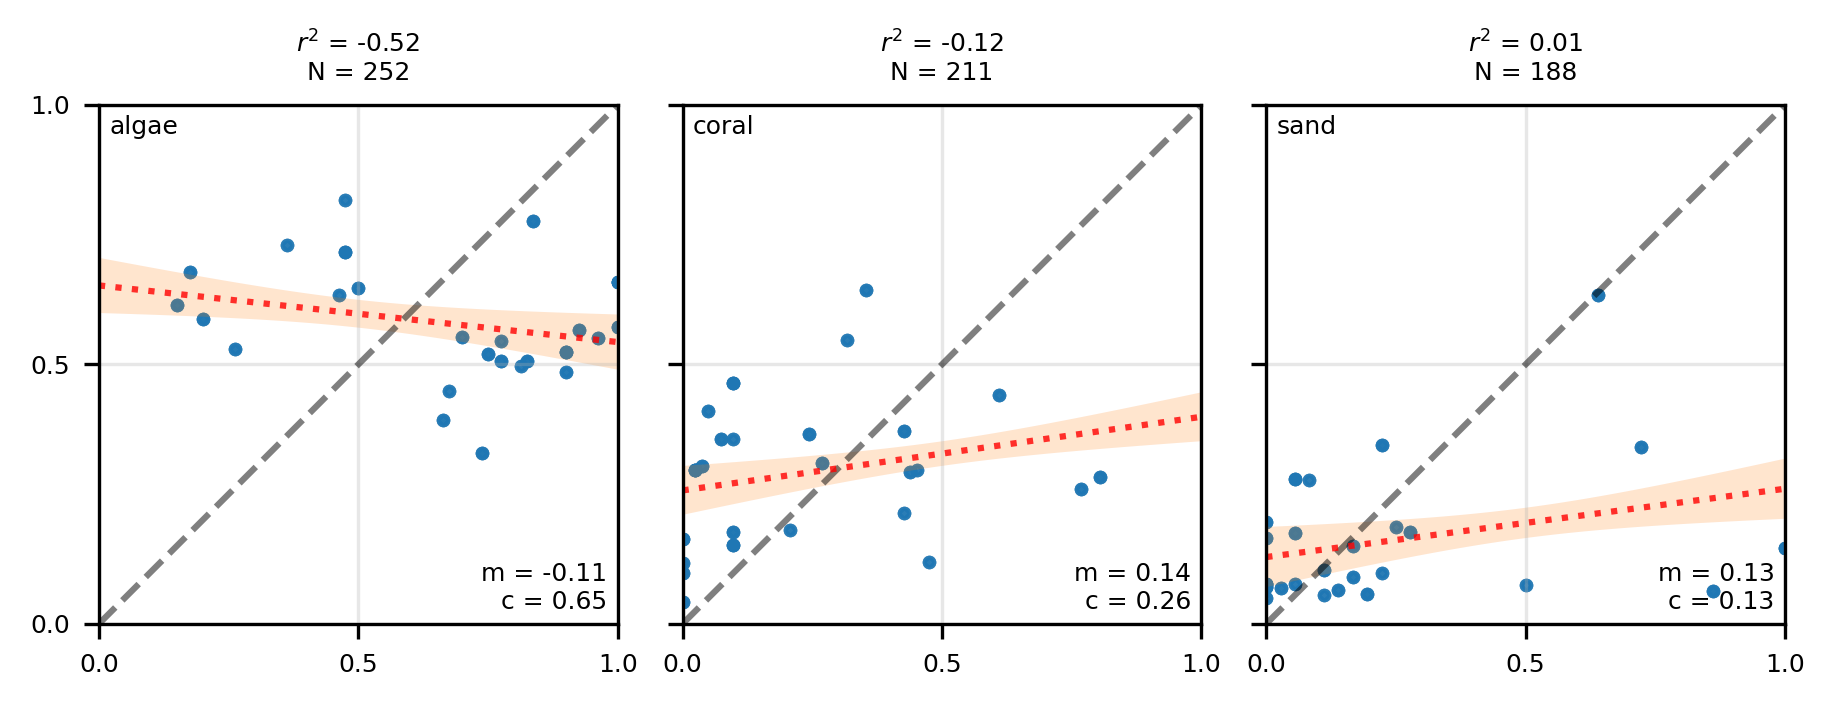

In [47]:
# find the closest pixel to each site in kbay_validation_data
kbay_validation_data["lat"] = kbay_validation_data.Y
kbay_validation_data["lon"] = kbay_validation_data.X
kbay_validation_data["pixel_x"] = np.argmin(np.abs(masked_endmember_rf_inferred.lon.values - kbay_validation_data.X.values[:, np.newaxis]), axis=1)
kbay_validation_data["pixel_y"] = np.argmin(np.abs(masked_endmember_rf_inferred.lat.values - kbay_validation_data.Y.values[:, np.newaxis]), axis=1)
# determine index of prediction from closest pixel
kbay_validation_data["pixel_index"] = kbay_validation_data.pixel_y * masked_endmember_rf_inferred.lon.shape[0] + kbay_validation_data.pixel_x
kbay_validation_data["algae_pred"] = all_predictions_df.values[kbay_validation_data.pixel_index][:,0]
kbay_validation_data["coral_pred"] = all_predictions_df.values[kbay_validation_data.pixel_index][:,1]
kbay_validation_data["sand_pred"] = all_predictions_df.values[kbay_validation_data.pixel_index][:,2]
# add boolean column for train or test data
kbay_validation_data["train-test"] = kbay_validation_data.index.isin(kbay_train_inds)
kbay_validation_data.columns

Index(['X', 'Y', 'Campaign', 'Locale', 'Station', 'TimeUTC', 'TimeLocal',
       'Depth', 'Metabolism', 'Optics', 'Comments', 'algCCA', 'algCyano',
       'algMacBrn', 'algMacGrn', 'algMacMix', 'algMacRed', 'algMacUnk',
       'algTurf', 'crlCoral', 'crlBleach', 'othOcto', 'othSeagr', 'othClam',
       'othInvert', 'othOther', 'othSponge', 'othUrchin', 'sedLimest',
       'sedMud', 'sedRubble', 'sedSand', 'ROInumber', 'Flightline', 'algae',
       'coral', 'sand', 'Depth_label', 'pixel_y', 'pixel_x', 'lat', 'lon',
       'pixel_index', 'algae_pred', 'coral_pred', 'sand_pred', 'train-test'],
      dtype='object')

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


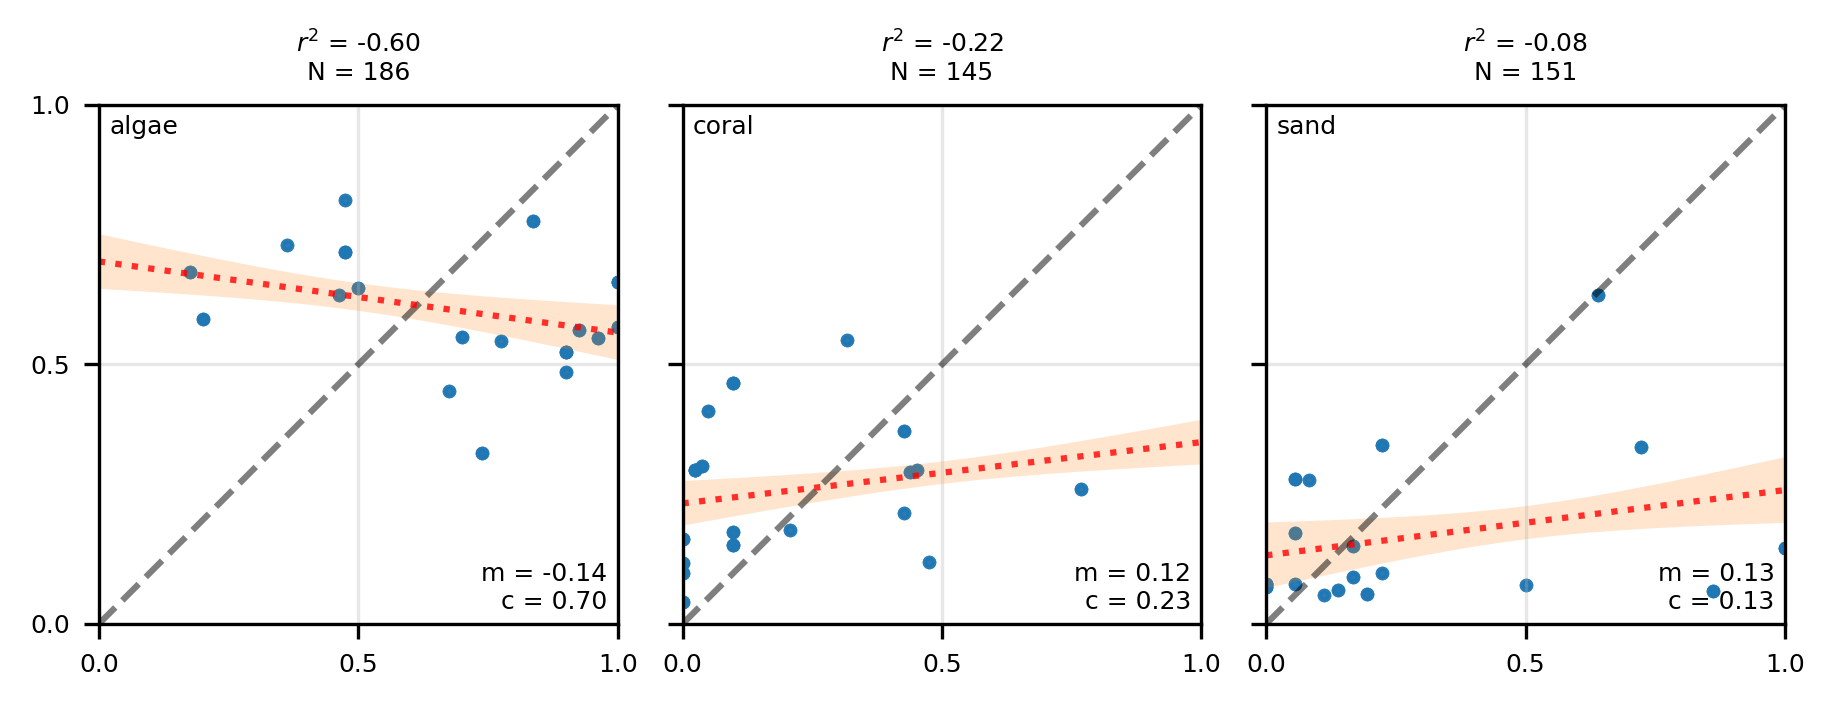

In [48]:
pred_data = kbay_validation_data[["algae_pred", "coral_pred", "sand_pred"]].values
pred_nan_inds = np.isnan(pred_data).any(axis=1)
pred_data = pred_data[~pred_nan_inds]

true_data = kbay_validation_data[["algae", "coral", "sand"]].values[~pred_nan_inds]
# scale true data 
scaler = MinMaxScaler()
scaler = scaler.fit(kbay_validation_data[["algae", "coral", "sand"]].loc[kbay_train_inds])  # scale on train data
test_data = pd.DataFrame(scaler.transform(true_data), columns=["algae", "coral", "sand"])

plotting.plot_regression_results(test_data, pred_data, benthic_labels,
                                #  metadata=kbay_validation_data.loc[pred_nan_inds], color_by="Depth"
                                 )

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


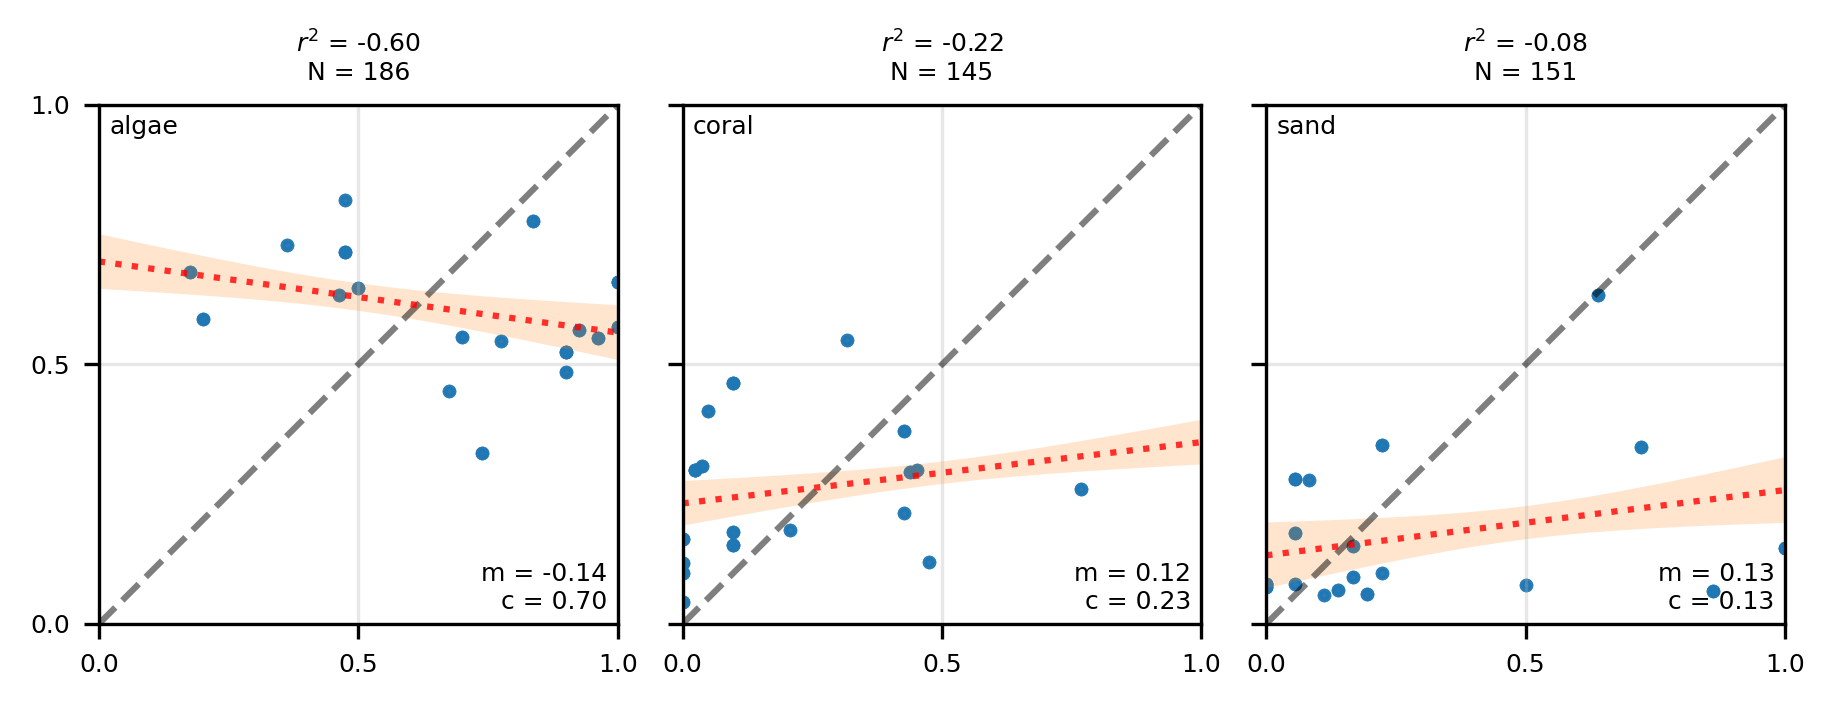

In [49]:

# scaler = scaler.fit(kbay_validation_data[["algae", "coral", "sand"]].loc[kbay_indices.intersection(kbay_validation_data.index)])  # scale on train data
# scale data by train scaler
# test_data = pd.DataFrame(scaler.transform(kbay_validation_data[["algae", "coral", "sand"]]), index=kbay_validation_data.index, columns=["coral", "algae", "sand"])
test_data = pd.DataFrame(scaler.transform(true_data), columns=["algae", "coral", "sand"])
# pred_data = kbay_validation_data[["algae_pred", "coral_pred", "sand_pred"]].values
labels = pd.DataFrame(kbay_validation_data[["algae", "coral", "sand"]], index=kbay_validation_data.index, columns=["algae", "coral", "sand"])


plotting.plot_regression_results(test_data, pred_data, labels,
                                #  metadata=kbay_validation_data.loc[pred_nan_inds], color_by="Depth"
                                 )

In [50]:
# depth predictions

scaler = MinMaxScaler()
scaler = scaler.fit(pd.DataFrame(kbay_validation_data["Depth"].loc[kbay_train_inds]))  # scale on train data
# scale data by train scaler
test_data = pd.DataFrame(scaler.transform(pd.DataFrame(kbay_validation_data["Depth"])), index=kbay_validation_data.index, columns=["Depth"])
pred_data = kbay_validation_data["Depth"].values

In [51]:
test_data

Depth
1151  0.370690
1152  0.370690
1153  0.370690
1154  0.370690
1155  0.318966
...        ...
1559  0.267241
1560  0.344828
1561  0.344828
1562  0.344828
1563  0.344828

[395 rows x 1 columns]

In [52]:
# scale ["coral", "algae", "sand"] columns in kbay_validation_data
# kbay_validation_data[["coral", "algae", "sand"]] = scaler.transform(kbay_validation_data[["coral", "algae", "sand"]])

train_results = kbay_validation_data[kbay_validation_data["train-test"] == True]
test_results = kbay_validation_data[kbay_validation_data["train-test"] == False]
train_results_true = train_results[["coral", "algae", "sand"]]
train_results_pred = train_results[["coral_pred", "algae_pred", "sand_pred"]]
test_results_true = test_results[["coral", "algae", "sand"]]
test_results_pred = test_results[["coral_pred", "algae_pred", "sand_pred"]]

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(train_results_true, train_results_pred, color="r", label="Train Data", alpha=0.5, s=5)
plt.scatter(test_results_true, test_results_pred, color="c", label="Test Data", alpha=0.5, s=5)
plt.plot([0, 1], [0, 1], color="k", lw=1, ls="--")
plt.axis("equal")
plt.xlim(0, 1)
plt.ylim(0, 1)

# r2_score(test_results_true, test_results_pred)

In [ ]:
# compare spectra
prism_spectra = spectrum_utils.preprocess_prism_spectra(spectrum_utils.load_spectra())
fit_fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/results/fits/fit_results_1.csv"
fits = pd.read_csv(fit_fp, header=[0,1])
fits = fits.fitted_spectra
fits.columns = fits.columns.astype(float)

plt.figure(figsize=(10, 5))
plt.plot(no_nan_hs_vals[::100].T, c="k", alpha=0.01);
plt.figure(figsize=(10, 5))
plt.plot(prism_spectra.T, c="r", alpha=0.02);
plt.plot(fits.T, c="c", alpha=0.01, zorder=10);
plt.xlim(prism_spectra.columns.min(), prism_spectra.columns.max());

In [ ]:
N = -1
spectra_source1 = no_nan_hs_vals.iloc[:N,:]
spectra_source2 = prism_spectra.iloc[:N,:]
spectra_source3 = fits.iloc[:N,:]
spectra_source2.shape[1]

In [ ]:
# statistically compare two batches of spectra

p_values = np.zeros(spectra_source1.shape[1])
for i in range(spectra_source1.shape[1]):
    stat, p_val = ks_2samp(spectra_source3.iloc[:, i], spectra_source2.iloc[:, i])
    p_values[i] = p_val
    
p_values

In [ ]:
# pca both distributions

pca1 = PCA(n_components=1)
pca1.fit(spectra_source3)
pca_source1 = pca1.transform(spectra_source1)
pca2 = PCA(n_components=1)
pca2.fit(spectra_source2)
pca_source2 = pca2.transform(spectra_source2)

# statistically compare pca components
stat, p_val = ks_2samp(pca_source1, pca_source2)
print(stat, p_val)

In [ ]:
ks_2samp(pca_source1, pca_source1)

In [ ]:

# Combine data from both sources and add a label
data = np.vstack([spectra_source1.values, spectra_source2.values])
labels = np.array([0]*spectra_source1.shape[0] + [1]*spectra_source2.shape[0])

# Perform MANOVA (multivariate analysis of variance)
manova = MANOVA(endog=data, exog=labels)
print(manova.mv_test())


- Predict depth and compare with LIDAR
- Use depth as a parameter